In [11]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
class Item:
    def __init__(self, value, _child = (),_op = '', label = ''):
        self.data = value
        self.label = label
        self._child = _child
        self.grad = 0
        self._prev = set(_child)
        self._op = _op
        self._backward = lambda: None
        
    def __repr__(self):
        return f"value(data = {self.data})"
    def __add__(self, other):
        other = other if isinstance(other, Item) else Item(other)
        out = Item(self.data + other.data, _child = (self, other), _op = '+')
        def _backward():
            self.grad += out.grad * 1
            other.grad += out.grad * 1
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * (other ** -1)

    def __pow__(self, other):
        assert isinstance(other, (float, int))
        w = self.data ** other
        out = Item(w, _child = (self,), _op = '^', label = "power")
        def _backward():
            self.grad += other * ((self.data)**(other - 1)) * out.grad  
        out._backward = _backward
        return out
        
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        out = Item(t, (self,), "tanh")
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
        
    def __mul__(self, other):
        other = other if isinstance(other, Item) else Item(other)
        out = Item(self.data * other.data, _child = (self, other), _op = '*')
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        return out
    def __sub__(self, other):
        return self + (-other)

    #topological sort
    def backward(ite):
        ite.grad = 1
        to = []
        visited = set()
        def build_topo(node):
            if node not in visited:
                visited.add(node)
                for child in node._child:
                    build_topo(child)
                to.append(node)
        build_topo(ite)
        for node in reversed(to):
            node._backward()
    def __rpow__(self, other):
        return self ** other
    def __rmul__(self, other):
        return self * other
    def __rsub__(self, other):
        return self + (-other)
    def __radd__(self, other):
        return self + other
    def __neg__(self):
        return self * (-1)
    

        

In [13]:
#2 ** b

In [14]:
a = Item(2, label = 'a')
b = Item(3, label = 'b')
c = a + b
c.label = 'c'
d = Item(-1, label = 'd')
e = d * c
e.label = 'e'
f = e.tanh()
f

value(data = -0.9999092042625951)

In [15]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')

        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this op node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


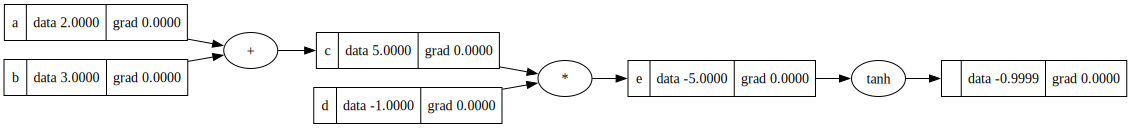

In [16]:
draw_dot(f)

In [17]:
f.backward()

In [18]:
import torch

In [19]:
a = torch.tensor([2.], requires_grad=True)
b = torch.tensor([3.], requires_grad=True)
d = torch.tensor([-1.], requires_grad=True)

c = a + b
c.retain_grad() 
e = c * d
e.retain_grad()
f = torch.tanh(e)
f.backward()


print("a.grad =", a.grad.item())
print("b.grad =", b.grad.item())
print("c.grad =", c.grad.item()) 
print("d.grad =", d.grad.item())
print("e.grad =", e.grad.item())  


a.grad = -0.00018155574798583984
b.grad = -0.00018155574798583984
c.grad = -0.00018155574798583984
d.grad = 0.0009077787399291992
e.grad = 0.00018155574798583984
